<a href="https://colab.research.google.com/github/zouhajar/IA_EMBARQUE_2/blob/Model/CIFAR10_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importation des bibliothèques

In [2]:

import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 2. Configuration de l’environnement d’exécution

In [3]:

gpus = tf.config.list_physical_devices('GPU')
print(" GPU détecté :", gpus if gpus else " CPU utilisé")

class Timer:
    def __init__(self): self.start = None
    def tic(self): self.start = time.time()
    def toc(self): return time.time() - self.start if self.start else 0

 GPU détecté : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3. Définition du bloc MobileNet léger


In [4]:

def mobilenet_block(x, filters, stride=1, expansion=2, weight_decay=1e-4):
    in_channels = x.shape[-1]
    expanded = in_channels * expansion

    # Expansion (1x1)
    if expansion != 1:
        x = layers.Conv2D(expanded, 1, padding="same", use_bias=False,
                          kernel_regularizer=regularizers.l2(weight_decay))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    # Depthwise
    x = layers.DepthwiseConv2D(3, strides=stride, padding="same", use_bias=False,
                               depthwise_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Projection
    x = layers.Conv2D(filters, 1, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    return x

## 4. Construction de l’architecture MobileNet compacte


In [5]:

def build_mobilenet_cifar10(input_shape, num_classes=10, weight_decay=1e-4):
    inputs = layers.Input(shape=input_shape)

    # Stem
    x = layers.Conv2D(8, 3, strides=1, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(weight_decay))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Blocs plus petits
    x = mobilenet_block(x, 8, stride=1, expansion=2)
    x = mobilenet_block(x, 16, stride=2, expansion=2)
    x = mobilenet_block(x, 24, stride=1, expansion=2)
    x = mobilenet_block(x, 32, stride=2, expansion=3)
    x = mobilenet_block(x, 48, stride=1, expansion=3)
    x = mobilenet_block(x, 64, stride=2, expansion=3)

    # Classifieur
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="MobileNet_STM32_Tiny")
    return model

## 5. Data augmentation

In [6]:

def augment_data(x, y):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(x)
    return datagen

## 6. Chargement et préparation du jeu de données CIFAR-10

In [7]:

def load_cifar10():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test  = x_test.astype("float32") / 255.0
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test  = tf.keras.utils.to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test


## 7. Entrainement

In [8]:

def train_model(x_train, y_train, x_val, y_val, nb_epochs=80, batch_size=64):
    model = build_mobilenet_cifar10(x_train.shape[1:])
    opt = tf.keras.optimizers.Adam(1e-3)
    lr_sched = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy", factor=0.5, patience=5, min_lr=1e-5, verbose=1)

    model.compile(optimizer=opt,
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=["accuracy"])

    datagen = augment_data(x_train, y_train)
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_val, y_val),
                        epochs=nb_epochs,
                        verbose=2,
                        callbacks=[lr_sched])
    return model, history
    model.summary

In [11]:

# ------------------------------
# MAIN
# ------------------------------
if __name__ == "__main__":
    NB_EPOCHS = 80
    BATCH_SIZE = 64
    x_train, y_train, x_test, y_test = load_cifar10()
    model, history = train_model(x_train, y_train, x_test, y_test,
                                 nb_epochs=NB_EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/80
782/782 - 62s - 79ms/step - accuracy: 0.3916 - loss: 1.8364 - val_accuracy: 0.4181 - val_loss: 1.8508 - learning_rate: 1.0000e-03
Epoch 2/80
782/782 - 27s - 35ms/step - accuracy: 0.5107 - loss: 1.6163 - val_accuracy: 0.4774 - val_loss: 1.7189 - learning_rate: 1.0000e-03
Epoch 3/80
782/782 - 27s - 35ms/step - accuracy: 0.5611 - loss: 1.5194 - val_accuracy: 0.5211 - val_loss: 1.6625 - learning_rate: 1.0000e-03
Epoch 4/80
782/782 - 28s - 35ms/step - accuracy: 0.5992 - loss: 1.4500 - val_accuracy: 0.5911 - val_loss: 1.4632 - learning_rate: 1.0000e-03
Epoch 5/80
782/782 - 28s - 36ms/step - accuracy: 0.6212 - loss: 1.4029 - val_accuracy: 0.6133 - val_loss: 1.4245 - learning_rate: 1.0000e-03
Epoch 6/80
782/782 - 27s - 35ms/step - accuracy: 0.6419 - loss: 1.3643 - val_accuracy: 0.6290 - val_loss: 1.4157 - learning_rate: 1.0000e-03
Epoch 7/80
782/782 - 27s - 35ms/step - accuracy: 0.6601 - loss: 1.3283 - val_accuracy: 0.6097 - val_loss: 1.4493 - learning_rate: 1.0000e-03
Epoch 8/80
78

## 8. Test et sauvegarde

Model: "MobileNet_STM32_Tiny"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 8)      │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 16)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_6              │ (None, 32, 32, 16)     │           144 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 8)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32, 32, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 16)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_7              │ (None, 16, 16, 16)     │           144 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 16)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 109,648 (428.32 KB)

 Trainable params: 35,914 (140.29 KB)

 Non-trainable params: 1,904 (7.44 KB)

 Optimizer params: 71,830 (280.59 KB)

313/313 - 1s - 3ms/step - accuracy: 0.8246 - loss: 0.9945
 Test accuracy: 82.46%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


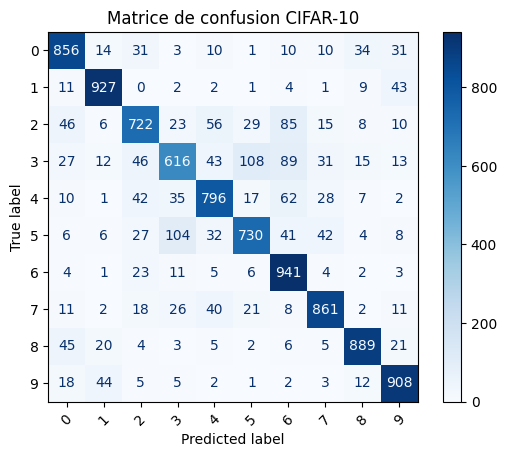

 Modèle et fichiers de test sauvegardés.


In [19]:
model.summary()
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f" Test accuracy: {acc*100:.2f}%")

# Prédictions
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matrice de confusion CIFAR-10")
plt.show()

# Sauvegarde du modèle et des données de test
np.save("CIFAR10_xtest.npy", x_test)
np.save("CIFAR10_ytest.npy", y_test)
model.save("CIFAR10_MobileNet_STM32_Tiny.h5")
print(" Modèle et fichiers de test sauvegardés.")
